In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [9]:
# Load all participant data
# Use absolute path to ensure we're reading from the correct location
import os
notebook_dir = Path(os.path.abspath(''))
project_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
data_dir = project_root / 'human_data'

print(f"Loading data from: {data_dir}")
print(f"Directory exists: {data_dir.exists()}")

participant_dirs = [d for d in data_dir.iterdir() if d.is_dir()]

# Define pixelation levels in order (from highest to lowest pixelation)
pixelation_levels = [6.5, 5.0, 4.2, 3.5, 3.0, 2.6, 2.3, 2.0, 1.8, 1.6, 1.4, 1.2, 1.0]

# Create mapping from pixelation level to time step
level_to_step = {level: step + 1 for step, level in enumerate(pixelation_levels)}

# Load and process data for each participant
all_data = []
participant_names = []

for participant_dir in sorted(participant_dirs):
    csv_path = participant_dir / 'results.csv'
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        print(f"\n{participant_dir.name}:")
        print(f"  Total rows in CSV: {len(df)}")
        
        # Filter out any duplicate header rows (where image_idx equals the string 'image_idx')
        before_clean = len(df)
        df = df[df["image_idx"] != "image_idx"].copy()
        if len(df) < before_clean:
            print(f"  Removed {before_clean - len(df)} duplicate header row(s)")
        
        print(f"  Rows with 'guess': {len(df[df['action_taken'] == 'guess'])}")
        
        # Filter to only rows where a guess was made
        guesses = df[df['action_taken'] == 'guess'].copy()
        
        # Convert 'correct' column from string to boolean
        # Handle both string 'True'/'False' and actual boolean values
        if guesses['correct'].dtype == 'object':
            # Fill NaN with 'False' first
            guesses['correct'] = guesses['correct'].fillna('False')
            # Convert to string and map
            guesses['correct'] = guesses['correct'].astype(str).str.strip().map({
                'True': True, 'False': False, 
                'true': True, 'false': False,
                'TRUE': True, 'FALSE': False,
                '': False
            })
            # Fill any remaining NaN (from unmapped values) with False
            guesses['correct'] = guesses['correct'].fillna(False)
        # Ensure it's boolean type
        guesses['correct'] = guesses['correct'].astype(bool)
        
        # Convert 'user_guess' to numeric (for confusion matrix)
        # Handle empty strings and non-numeric values
        guesses['user_guess'] = pd.to_numeric(guesses['user_guess'], errors='coerce')
        # Ensure user_guess is within valid range [0, 9]
        guesses['user_guess'] = guesses['user_guess'].clip(lower=0, upper=9)
        
        # Convert pixelation_level to numeric first
        guesses['pixelation_level'] = pd.to_numeric(guesses['pixelation_level'], errors='coerce')
        
        # Calculate time step based on pixelation level
        # Use map with nearest match for values not exactly in the mapping
        def get_time_step(level):
            if pd.isna(level):
                return None
            # First try exact match
            if level in level_to_step:
                return level_to_step[level]
            # Otherwise find the closest value
            closest_level = min(level_to_step.keys(), key=lambda x: abs(x - level))
            return level_to_step[closest_level]
        
        guesses['time_step'] = guesses['pixelation_level'].apply(get_time_step)
        
        # Drop rows with NaN time_step (shouldn't happen, but just in case)
        before_drop = len(guesses)
        guesses = guesses.dropna(subset=['time_step'])
        if len(guesses) < before_drop:
            print(f"  Warning: Dropped {before_drop - len(guesses)} rows with invalid pixelation_level")
        
        # Ensure numeric columns are properly typed
        guesses['image_idx'] = pd.to_numeric(guesses['image_idx'], errors='coerce').astype('Int64')
        guesses['class_label'] = pd.to_numeric(guesses['class_label'], errors='coerce').astype('Int64')
        
        # Add participant identifier (anonymized)
        participant_name = f"Participant {len(participant_names) + 1}"
        guesses['participant'] = participant_name
        
        all_data.append(guesses)
        participant_names.append(participant_name)
        print(f"  Loaded {len(guesses)} guesses")

# Combine all data
combined_data = pd.concat(all_data, ignore_index=True)

print(f"\n{'='*50}")
print(f"Loaded data from {len(participant_names)} participants")
print(f"Total guesses: {len(combined_data)}")
print(f"\nParticipant breakdown:")
for name in participant_names:
    count = len(combined_data[combined_data['participant'] == name])
    print(f"  {name}: {count} guesses")

Loading data from: /Users/brianrapanan/966-project/human_data
Directory exists: True

Brian:
  Total rows in CSV: 2380
  Removed 1 duplicate header row(s)
  Rows with 'guess': 400
  Loaded 400 guesses

CJ:
  Total rows in CSV: 643
  Rows with 'guess': 100
  Loaded 100 guesses

Ethan:
  Total rows in CSV: 231
  Rows with 'guess': 52
  Loaded 52 guesses

Hutch:
  Total rows in CSV: 180
  Rows with 'guess': 35
  Loaded 35 guesses

Malachi:
  Total rows in CSV: 324
  Rows with 'guess': 51
  Loaded 51 guesses

Loaded data from 5 participants
Total guesses: 638

Participant breakdown:
  Participant 1: 400 guesses
  Participant 2: 100 guesses
  Participant 3: 52 guesses
  Participant 4: 35 guesses
  Participant 5: 51 guesses


Using combined_data with 638 total guesses
Data shape: (638, 8)


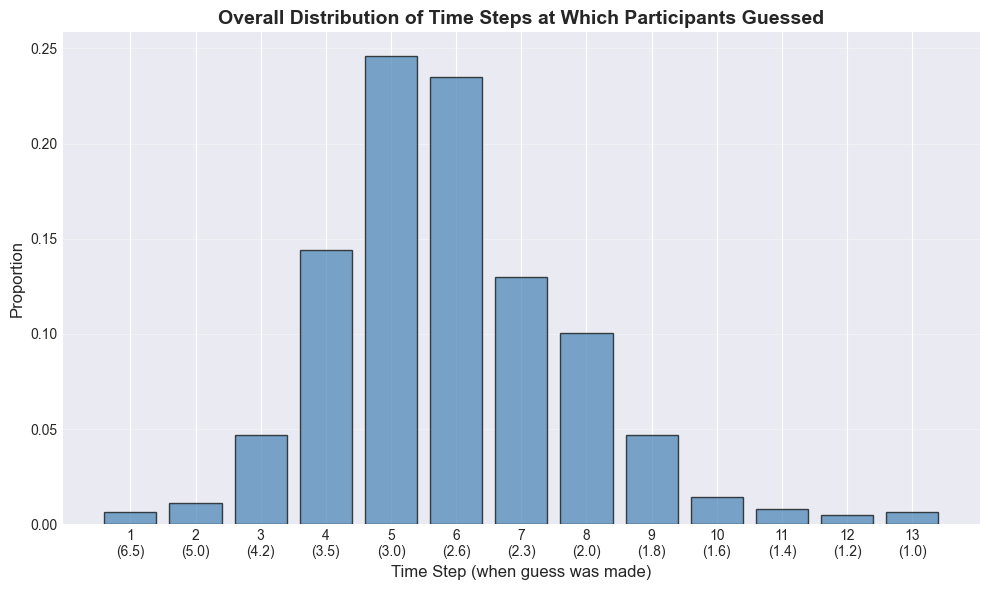

In [10]:
# Plot 1: Overall distribution (histogram) of time steps at which participants guessed
# Verify we're using fresh data
print(f"Using combined_data with {len(combined_data)} total guesses")
print(f"Data shape: {combined_data.shape}")

# Count occurrences of each time step and calculate proportions
time_step_counts = combined_data['time_step'].value_counts().sort_index()
time_step_proportions = time_step_counts / len(combined_data)

plt.figure(figsize=(10, 6))
plt.bar(time_step_proportions.index, time_step_proportions.values, 
        edgecolor='black', alpha=0.7, color='steelblue', width=0.8)
plt.xlabel('Time Step (when guess was made)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Overall Distribution of Time Steps at Which Participants Guessed', fontsize=14, fontweight='bold')

# Create labels with time step and pixelation level
x_labels = [f'{i}\n({pixelation_levels[i-1]})' for i in range(1, len(pixelation_levels) + 1)]
plt.xticks(range(1, len(pixelation_levels) + 1), x_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

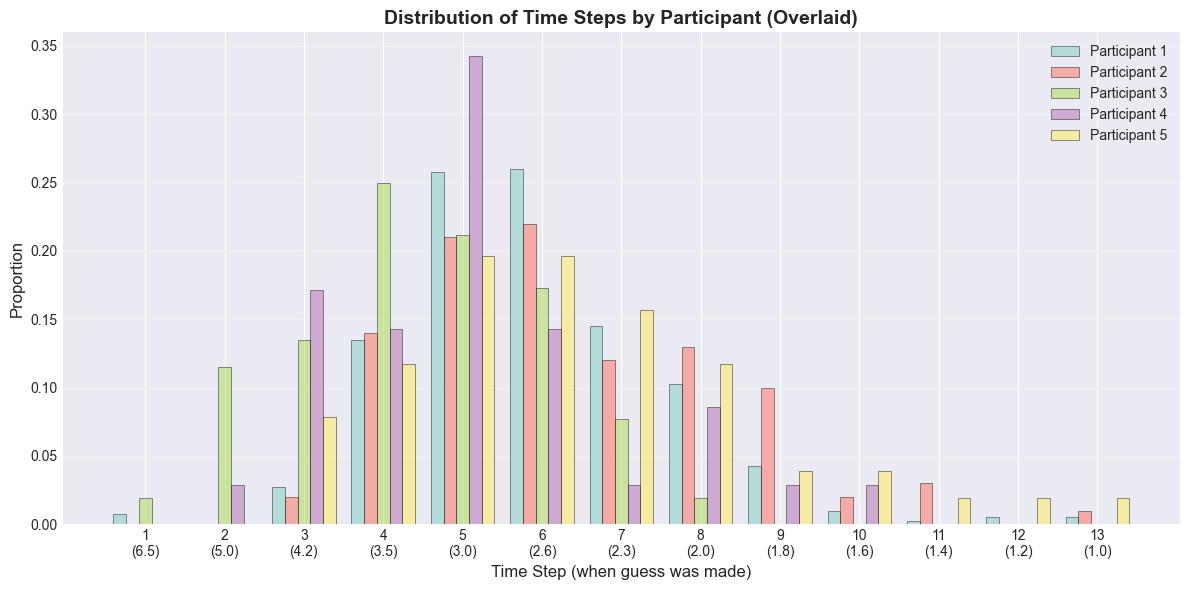

In [11]:
# Plot 2: Overlaid distributions with each color corresponding to a participant
plt.figure(figsize=(12, 6))

# Get unique participants and assign colors
participants = combined_data['participant'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(participants)))

# Set up x positions for bars (with slight offset for each participant)
x_positions = np.arange(1, len(pixelation_levels) + 1)
bar_width = 0.8 / len(participants)  # Width of each bar

for i, participant in enumerate(sorted(participants)):
    participant_data = combined_data[combined_data['participant'] == participant]
    # Count occurrences and calculate proportions
    counts = participant_data['time_step'].value_counts().sort_index()
    proportions = counts / len(participant_data)
    
    # Create positions for this participant's bars (slightly offset)
    x_offset = (i - len(participants)/2 + 0.5) * bar_width
    x_pos = x_positions + x_offset
    
    # Create a full array of proportions for all time steps
    full_proportions = np.zeros(len(pixelation_levels))
    for ts in proportions.index:
        if 1 <= ts <= len(pixelation_levels):
            full_proportions[int(ts) - 1] = proportions[ts]
    
    plt.bar(x_pos, full_proportions, width=bar_width,
            alpha=0.6, label=participant, color=colors[i], edgecolor='black', linewidth=0.5)

plt.xlabel('Time Step (when guess was made)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Distribution of Time Steps by Participant (Overlaid)', fontsize=14, fontweight='bold')

# Create labels with time step and pixelation level
x_labels = [f'{i}\n({pixelation_levels[i-1]})' for i in range(1, len(pixelation_levels) + 1)]
plt.xticks(range(1, len(pixelation_levels) + 1), x_labels)
plt.legend(loc='best', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

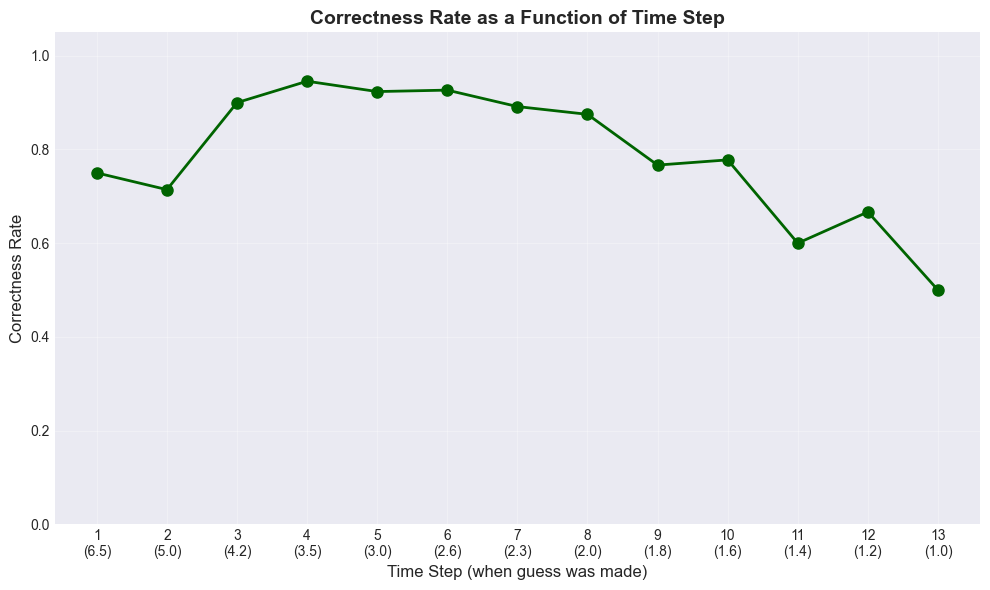

Correctness by time step:
    time_step  correctness_rate  count
0           1          0.750000      4
1           2          0.714286      7
2           3          0.900000     30
3           4          0.945652     92
4           5          0.923567    157
5           6          0.926667    150
6           7          0.891566     83
7           8          0.875000     64
8           9          0.766667     30
9          10          0.777778      9
10         11          0.600000      5
11         12          0.666667      3
12         13          0.500000      4


In [12]:
# Plot 3: Correctness as a function of time step they guessed
# Calculate correctness rate for each time step
correctness_by_step = combined_data.groupby('time_step')['correct'].agg(['mean', 'count']).reset_index()
correctness_by_step.columns = ['time_step', 'correctness_rate', 'count']

plt.figure(figsize=(10, 6))
plt.plot(correctness_by_step['time_step'], correctness_by_step['correctness_rate'], 
         marker='o', linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('Time Step (when guess was made)', fontsize=12)
plt.ylabel('Correctness Rate', fontsize=12)
plt.title('Correctness Rate as a Function of Time Step', fontsize=14, fontweight='bold')

# Create labels with time step and pixelation level
x_labels = [f'{i}\n({pixelation_levels[i-1]})' for i in range(1, len(pixelation_levels) + 1)]
plt.xticks(range(1, len(pixelation_levels) + 1), x_labels)
plt.ylim([0, 1.05])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print some statistics
print("Correctness by time step:")
print(correctness_by_step)

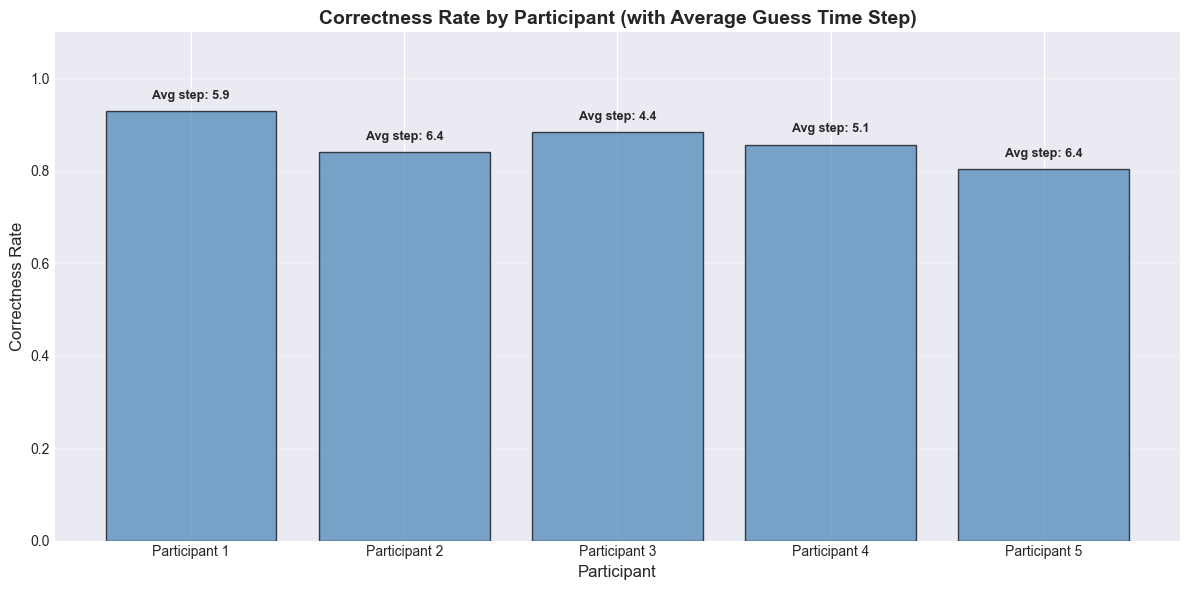


Participant Statistics:
  participant  correctness_rate  avg_time_step
Participant 1          0.930000       5.947500
Participant 2          0.840000       6.430000
Participant 3          0.884615       4.442308
Participant 4          0.857143       5.142857
Participant 5          0.803922       6.352941


In [13]:
# Plot 4: Correctness by subject with their average guess time included
participant_stats = combined_data.groupby('participant').agg({
    'correct': 'mean',
    'time_step': 'mean'
}).reset_index()
participant_stats.columns = ['participant', 'correctness_rate', 'avg_time_step']

# Sort by participant name for consistent ordering
participant_stats = participant_stats.sort_values('participant')

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot for correctness
x_pos = np.arange(len(participant_stats))
bars = ax.bar(x_pos, participant_stats['correctness_rate'], 
              alpha=0.7, color='steelblue', edgecolor='black')

# Add average time step as text annotation on each bar
for i, (idx, row) in enumerate(participant_stats.iterrows()):
    ax.text(i, row['correctness_rate'] + 0.02, 
            f"Avg step: {row['avg_time_step']:.1f}", 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Participant', fontsize=12)
ax.set_ylabel('Correctness Rate', fontsize=12)
ax.set_title('Correctness Rate by Participant (with Average Guess Time Step)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(participant_stats['participant'], rotation=0)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nParticipant Statistics:")
print(participant_stats.to_string(index=False))

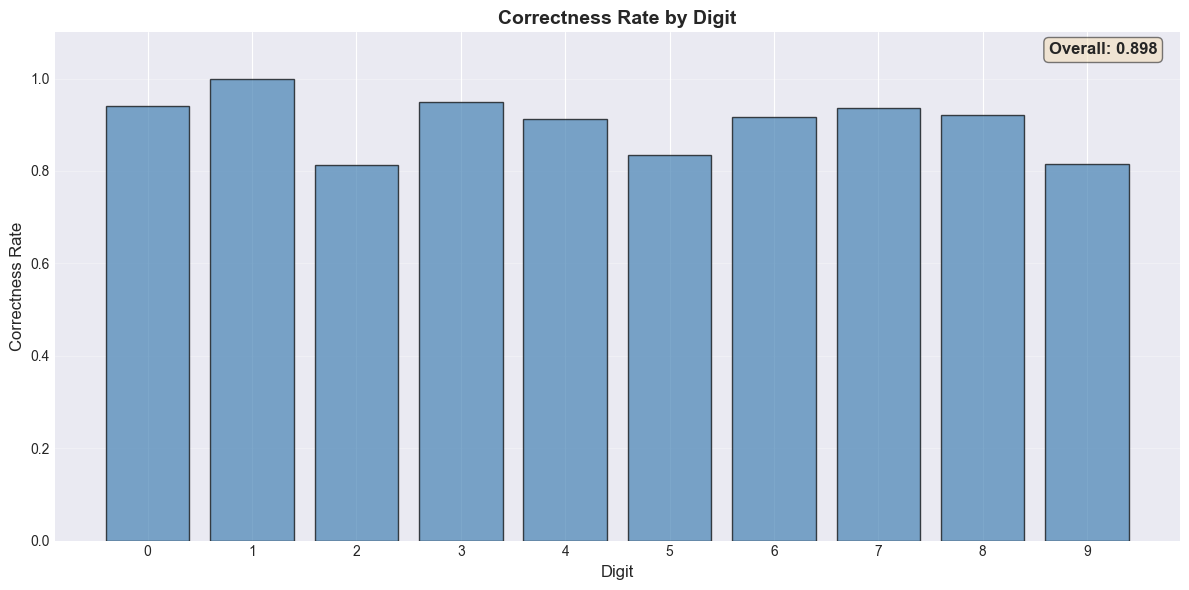


Correctness by digit:
 digit  correctness_rate  count
     0          0.941176     51
     1          1.000000     62
     2          0.812500     64
     3          0.948276     58
     4          0.913043     69
     5          0.835294     85
     6          0.916667     60
     7          0.936508     63
     8          0.920000     50
     9          0.815789     76


In [14]:
# Plot 5: Correctness by digit
correctness_by_digit = combined_data.groupby('class_label')['correct'].agg(['mean', 'count']).reset_index()
correctness_by_digit.columns = ['digit', 'correctness_rate', 'count']
correctness_by_digit = correctness_by_digit.sort_values('digit')

# Calculate overall correctness
overall_correctness = combined_data['correct'].mean()

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot for correctness by digit
x_pos = np.arange(len(correctness_by_digit))
bars = ax.bar(x_pos, correctness_by_digit['correctness_rate'], 
              alpha=0.7, color='steelblue', edgecolor='black')

# Add overall correctness in top right corner
ax.text(0.98, 0.98, f'Overall: {overall_correctness:.3f}', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Digit', fontsize=12)
ax.set_ylabel('Correctness Rate', fontsize=12)
ax.set_title('Correctness Rate by Digit', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(correctness_by_digit['digit'], rotation=0)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nCorrectness by digit:")
print(correctness_by_digit.to_string(index=False))

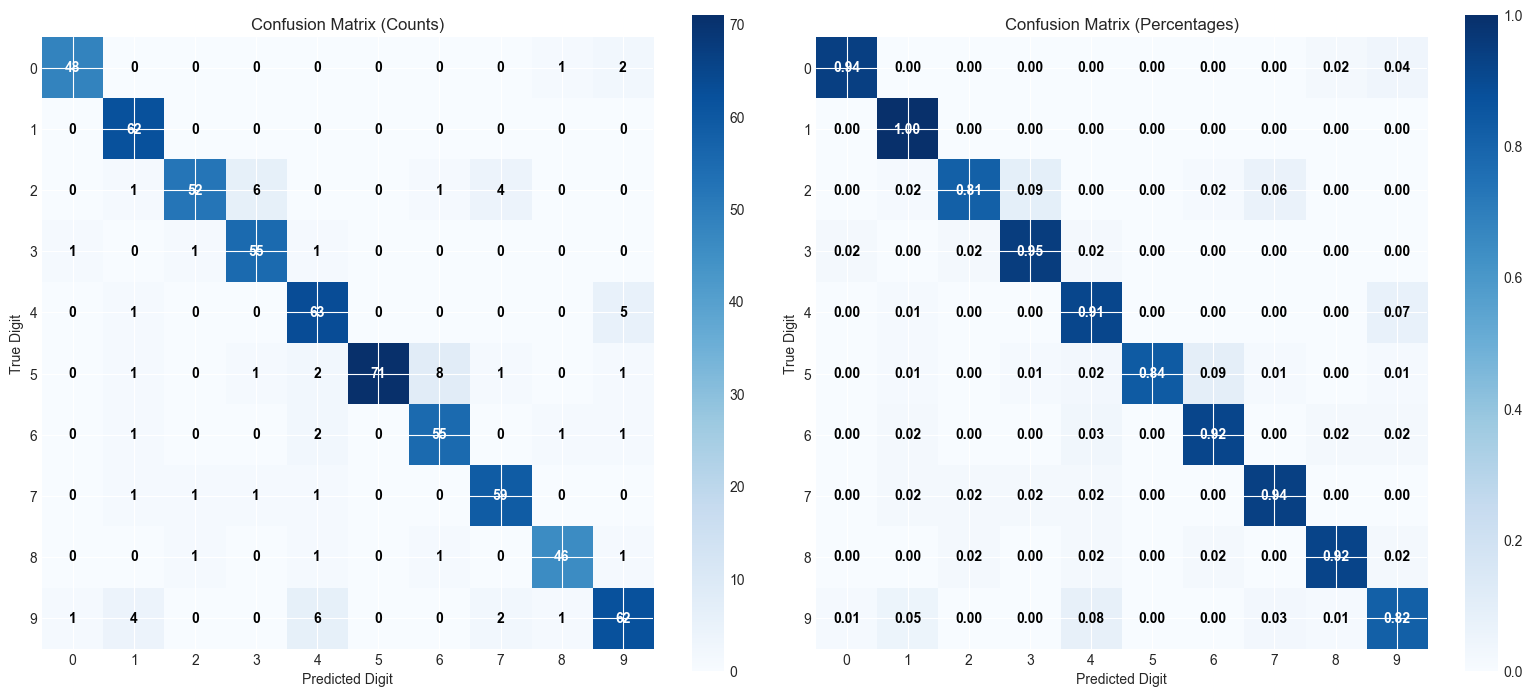


Confusion Matrix Summary:
Total guesses: 638
Correct guesses: 573
Overall accuracy: 0.898

Per-digit accuracy (diagonal):
  Digit 0: 48/51 = 0.941
  Digit 1: 62/62 = 1.000
  Digit 2: 52/64 = 0.812
  Digit 3: 55/58 = 0.948
  Digit 4: 63/69 = 0.913
  Digit 5: 71/85 = 0.835
  Digit 6: 55/60 = 0.917
  Digit 7: 59/63 = 0.937
  Digit 8: 46/50 = 0.920
  Digit 9: 62/76 = 0.816


In [15]:
# Plot 6: Confusion Matrix
from sklearn.metrics import confusion_matrix

# Filter out any rows with NaN user_guess (shouldn't happen, but just in case)
valid_data = combined_data.dropna(subset=['user_guess', 'class_label'])

# Create confusion matrix
cm = confusion_matrix(valid_data['class_label'], valid_data['user_guess'], labels=range(10))

# Normalize to get percentages (handle division by zero)
row_sums = cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.divide(cm.astype('float'), row_sums, out=np.zeros_like(cm.astype('float')), where=row_sums!=0)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Raw counts
im1 = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
ax1.figure.colorbar(im1, ax=ax1)
ax1.set(xticks=np.arange(10),
         yticks=np.arange(10),
         xticklabels=range(10),
         yticklabels=range(10),
         title='Confusion Matrix (Counts)',
         ylabel='True Digit',
         xlabel='Predicted Digit')

# Add text annotations for counts
thresh = cm.max() / 2.
for i in range(10):
    for j in range(10):
        ax1.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontweight='bold')

# Plot 2: Normalized (percentages)
im2 = ax2.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
ax2.figure.colorbar(im2, ax=ax2)
ax2.set(xticks=np.arange(10),
         yticks=np.arange(10),
         xticklabels=range(10),
         yticklabels=range(10),
         title='Confusion Matrix (Percentages)',
         ylabel='True Digit',
         xlabel='Predicted Digit')

# Add text annotations for percentages
thresh = cm_normalized.max() / 2.
for i in range(10):
    for j in range(10):
        ax2.text(j, i, format(cm_normalized[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black",
                fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nConfusion Matrix Summary:")
print(f"Total guesses: {len(valid_data)}")
print(f"Correct guesses: {np.trace(cm)}")
print(f"Overall accuracy: {np.trace(cm) / len(valid_data):.3f}")
print(f"\nPer-digit accuracy (diagonal):")
for i in range(10):
    total = cm[i, :].sum()
    correct = cm[i, i]
    if total > 0:
        print(f"  Digit {i}: {correct}/{total} = {correct/total:.3f}")